# AgrofusionNet A Lightweight and Scalable Deep Learning Model for Multi-Crop Desease Detection

In [1]:
# Import all required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast, GradScaler 
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)

In [2]:
# --- Index 1: GPU Setup and Configuration ---
print("=== GPU Configuration for RTX 3060 Ti ===")

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
    
    # Optimize for RTX GPU
    torch.backends.cudnn.benchmark = True  # Faster convolutions
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for matmul
    torch.backends.cudnn.allow_tf32 = True  # Allow TF32 for convolutions
    
    # Clear GPU cache
    torch.cuda.empty_cache()
else:
    print("No GPU available. Using CPU (training will be slower).")

# Set batch size based on GPU memory
batch_size = 16 if torch.cuda.is_available() else 8
print(f"Using batch size: {batch_size}")

=== GPU Configuration for RTX 3060 Ti ===
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Ti
GPU Memory: 8.0 GB
CUDA version: 12.1
Using batch size: 16


## Data exploration


=== Data Exploration  ===
Found 6 crop types: ['corn', 'jute', 'potato', 'rice', 'sugarcane', 'wheat']
  corn_cercospora_leaf_spot: 67 images
  corn_common_rust: 0 images
  corn_healthy: 1139 images
  corn_northern_leaf_blight: 115 images
  jute_cescospora_leaf_spot: 309 images
  jute_golden_mosaic: 347 images
  jute_healthy_leaf: 264 images
  potato_bacteria: 342 images
  potato_fungi: 452 images
  potato_healthy: 175 images
  potato_nematode: 47 images
  potato_pest: 415 images
  potato_phytopthora: 151 images
  potato_virus: 303 images
  rice_bacterial_leaf_blight: 78 images
  rice_brown_spot: 390 images
  rice_healthy: 438 images
  rice_leaf_blast: 438 images
  rice_leaf_scald: 438 images
  rice_narrow_brown_spot: 438 images
  sugarcane_healthy: 522 images
  sugarcane_mosaic: 462 images
  sugarcane_redrot: 518 images
  sugarcane_rust: 514 images
  sugarcane_yellow: 505 images
  wheat_brown_rust: 1256 images
  wheat_healthy: 1591 images
  wheat_septoria: 349 images
  wheat_smut: 93

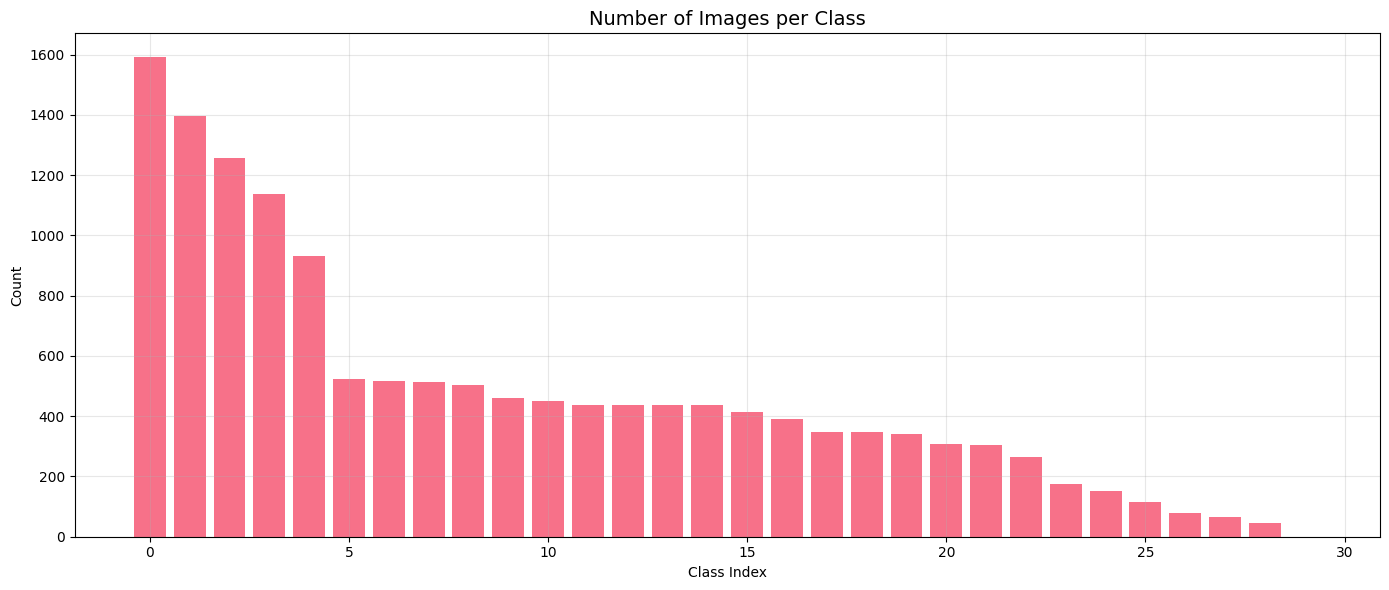


Sample images from each class:


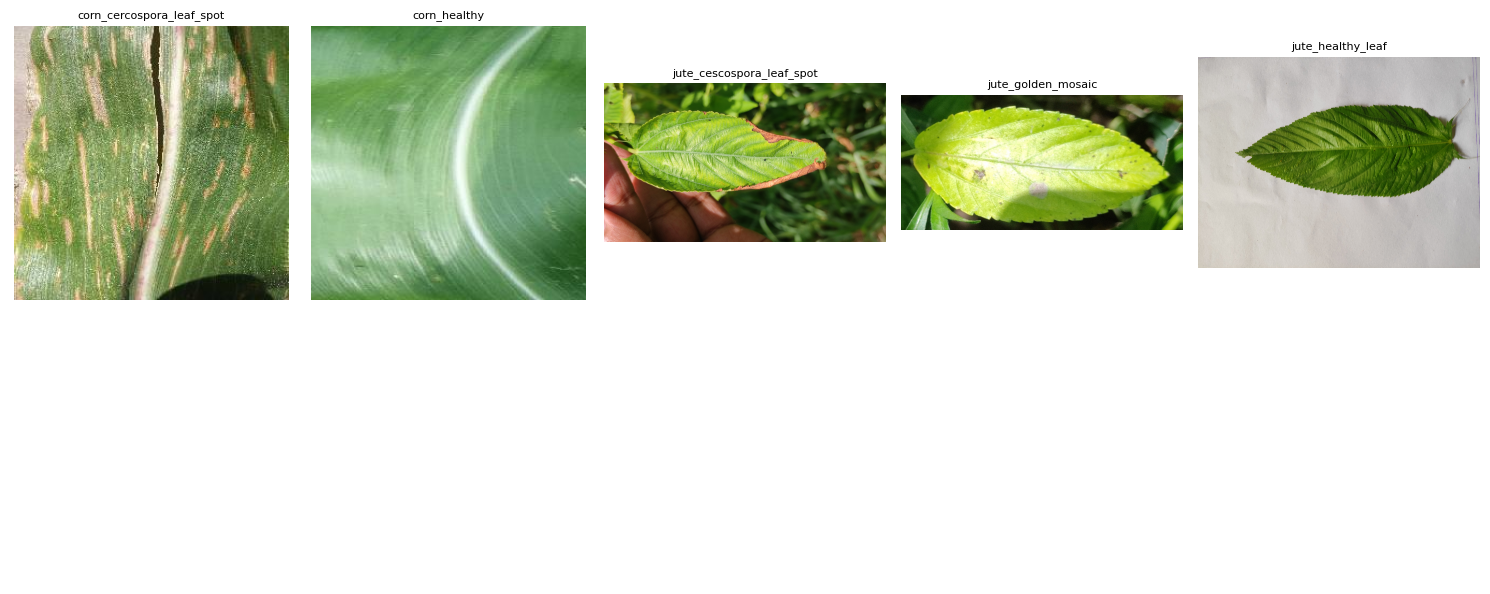


Dataset Statistics:
Total images: 14388
Average images per class: 479.6
Minimum images per class: 0
Maximum images per class: 1591


In [3]:
print("\n=== Data Exploration  ===")
ImageFile.LOAD_TRUNCATED_IMAGES = True
def explore_dataset_2level(data_path):
    if not os.path.exists(data_path):
        print(f"Error: Dataset not found at {data_path}")
        print("Please place your dataset in data/raw/agrofusionnet_dataset/")
        return None
    
    # Get all crop folders
    crop_folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print(f"Found {len(crop_folders)} crop types: {crop_folders}")
    
    # Count images per class (crop + disease)
    class_counts = []
    all_classes = []
    
    for crop in crop_folders:
        crop_path = os.path.join(data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders:
            disease_path = os.path.join(crop_path, disease)
            num_images = len([f for f in os.listdir(disease_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            
            class_name = f"{crop}_{disease}"
            class_counts.append((class_name, num_images))
            all_classes.append(class_name)
            
            print(f"  {class_name}: {num_images} images")
    
    # Create DataFrame
    df = pd.DataFrame(class_counts, columns=['Class', 'Count'])
    df = df.sort_values('Count', ascending=False)
    
    print(f"\nTotal {len(df)} classes found")
    print("\nTop 10 classes by image count:")
    print(df.head(10))
    
    # Plot class distribution
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(df)), df['Count'])
    plt.title('Number of Images per Class', fontsize=14)
    plt.xlabel('Class Index')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('C:/Users/ZA SEYAM/AgroFusionNet/results/class_distribution_raw.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display sample images
    print("\nSample images from each class:")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    sample_count = 0
    for crop in crop_folders[:2]:  # Show samples from first 2 crops
        crop_path = os.path.join(data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders[:3]:  # Show samples from first 3 diseases per crop
            if sample_count >= 10:  # Only show 10 samples
                break
                
            disease_path = os.path.join(crop_path, disease)
            images = [f for f in os.listdir(disease_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            if images:
                img_path = os.path.join(disease_path, images[0])
                img = Image.open(img_path)
                
                row, col = sample_count // 5, sample_count % 5
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"{crop}_{disease}", fontsize=8)
                axes[row, col].axis('off')
                
                sample_count += 1
    
    # Hide empty subplots
    for i in range(sample_count, 10):
        row, col = i // 5, i % 5
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('C:/Users/ZA SEYAM/AgroFusionNet/results/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate dataset statistics
    print("\nDataset Statistics:")
    print(f"Total images: {df['Count'].sum()}")
    print(f"Average images per class: {df['Count'].mean():.1f}")
    print(f"Minimum images per class: {df['Count'].min()}")
    print(f"Maximum images per class: {df['Count'].max()}")
    
    return df, all_classes

# Explore the dataset with 2-level structure
data_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/raw/agrofusionnet_dataset"
df, all_classes = explore_dataset_2level(data_path)

## Data Preprocessing

In [4]:
print("\n=== Data Preprocessing ===")

def organize_dataset(raw_data_path, processed_data_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split dataset into train, validation, and test sets for 2-level structure"""
    if not os.path.exists(raw_data_path):
        print(f"Error: Raw dataset not found at {raw_data_path}")
        return
    
    # If processed path already exists, clear it to avoid duplicates
    if os.path.exists(processed_data_path):
        shutil.rmtree(processed_data_path)
    os.makedirs(processed_data_path, exist_ok=True)
    
    # Get all crop folders
    crop_folders = [d for d in os.listdir(raw_data_path) if os.path.isdir(os.path.join(raw_data_path, d))]
    print(f"Found {len(crop_folders)} crop types: {crop_folders}")
    
    # Create directories for each split
    for split in ['train', 'validation', 'test']:
        os.makedirs(os.path.join(processed_data_path, split), exist_ok=True)
    
    # Process each crop and disease
    for crop in crop_folders:
        crop_path = os.path.join(raw_data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders:
            disease_path = os.path.join(crop_path, disease)
            class_name = f"{crop}_{disease}"
            
            # Create class directories in each split
            for split in ['train', 'validation', 'test']:
                os.makedirs(os.path.join(processed_data_path, split, class_name), exist_ok=True)
            
            print(f"Processing {class_name}...")
            
            # Get all images
            images = [f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if not images:
                print(f"  No images found in {class_name}")
                continue
            
            # Split images
            train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
            val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)
            
            print(f"  {len(train_imgs)} train, {len(val_imgs)} validation, {len(test_imgs)} test")
            
            # Function to copy only valid images
            def copy_images(img_list, split_name):
                for img in img_list:
                    src = os.path.join(disease_path, img)
                    dst = os.path.join(processed_data_path, split_name, class_name, img)
                    try:
                        with Image.open(src) as im:
                            im.verify()  # check if image is valid
                        shutil.copy2(src, dst)
                    except Exception as e:
                        print(f"⚠️ Skipping corrupted image: {src} ({e})")
            
            # Copy valid images to respective directories
            copy_images(train_imgs, 'train')
            copy_images(val_imgs, 'validation')
            copy_images(test_imgs, 'test')
    
    print("✅ Dataset organization completed!")
    
    # Verify the processed dataset
    train_path = os.path.join(processed_data_path, "train")
    val_path = os.path.join(processed_data_path, "validation")
    test_path = os.path.join(processed_data_path, "test")
    
    print(f"\nTrain set: {sum([len(files) for r, d, files in os.walk(train_path)])} images")
    print(f"Validation set: {sum([len(files) for r, d, files in os.walk(val_path)])} images")
    print(f"Test set: {sum([len(files) for r, d, files in os.walk(test_path)])} images")

# Define transforms (same as before)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined successfully!")

# Run preprocessing if dataset exists
raw_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/raw/agrofusionnet_dataset"
processed_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/processed"

if os.path.exists(raw_path):
    organize_dataset(raw_path, processed_path)
else:
    print(f"Raw dataset not found at {raw_path}. Please add your dataset and run this cell again.")



=== Data Preprocessing ===
Transforms defined successfully!
Found 6 crop types: ['corn', 'jute', 'potato', 'rice', 'sugarcane', 'wheat']
Processing corn_cercospora_leaf_spot...
  359 train, 77 validation, 77 test
Processing corn_common_rust...
  834 train, 179 validation, 179 test
Processing corn_healthy...
  811 train, 174 validation, 175 test
Processing corn_northern_leaf_blight...
  689 train, 148 validation, 148 test
Processing jute_cescospora_leaf_spot...
  216 train, 46 validation, 47 test
Processing jute_golden_mosaic...
  242 train, 52 validation, 53 test
Processing jute_healthy_leaf...
  184 train, 40 validation, 40 test
Processing potato_bacteria...
  398 train, 85 validation, 86 test
Processing potato_fungi...
  523 train, 112 validation, 113 test
Processing potato_healthy...
  140 train, 30 validation, 31 test
Processing potato_nematode...
  47 train, 10 validation, 11 test
Processing potato_pest...
  427 train, 92 validation, 92 test
Processing potato_phytopthora...
  242

## Plot the dataset

In [5]:
def plot_split_distribution(processed_data_path, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)  # make sure results folder exists
    
    data = []
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(processed_data_path, split)
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
                data.append([class_name, split, count])
    
    df = pd.DataFrame(data, columns=['Class','Split','Count'])
    
    # Pivot for grouped bar chart
    pivot_df = df.pivot(index='Class', columns='Split', values='Count').fillna(0)
    
    # Split into two halves for readability
    classes = pivot_df.index.tolist()
    mid = len(classes) // 2
    halves = [pivot_df.iloc[:mid], pivot_df.iloc[mid:]]
    
    fig, axes = plt.subplots(2, 1, figsize=(16,12), sharey=True)
    
    for i, half in enumerate(halves):
        ax = half.plot(kind='bar', ax=axes[i])
        ax.set_ylabel("Number of Images")
        ax.set_title(f"Dataset Split Distribution (Part {i+1})")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        
        # Add counts on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(str(int(height)), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=7, rotation=90)
    
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(save_dir, "dataset_split_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Split distribution saved at: {save_path}")
    return pivot_df

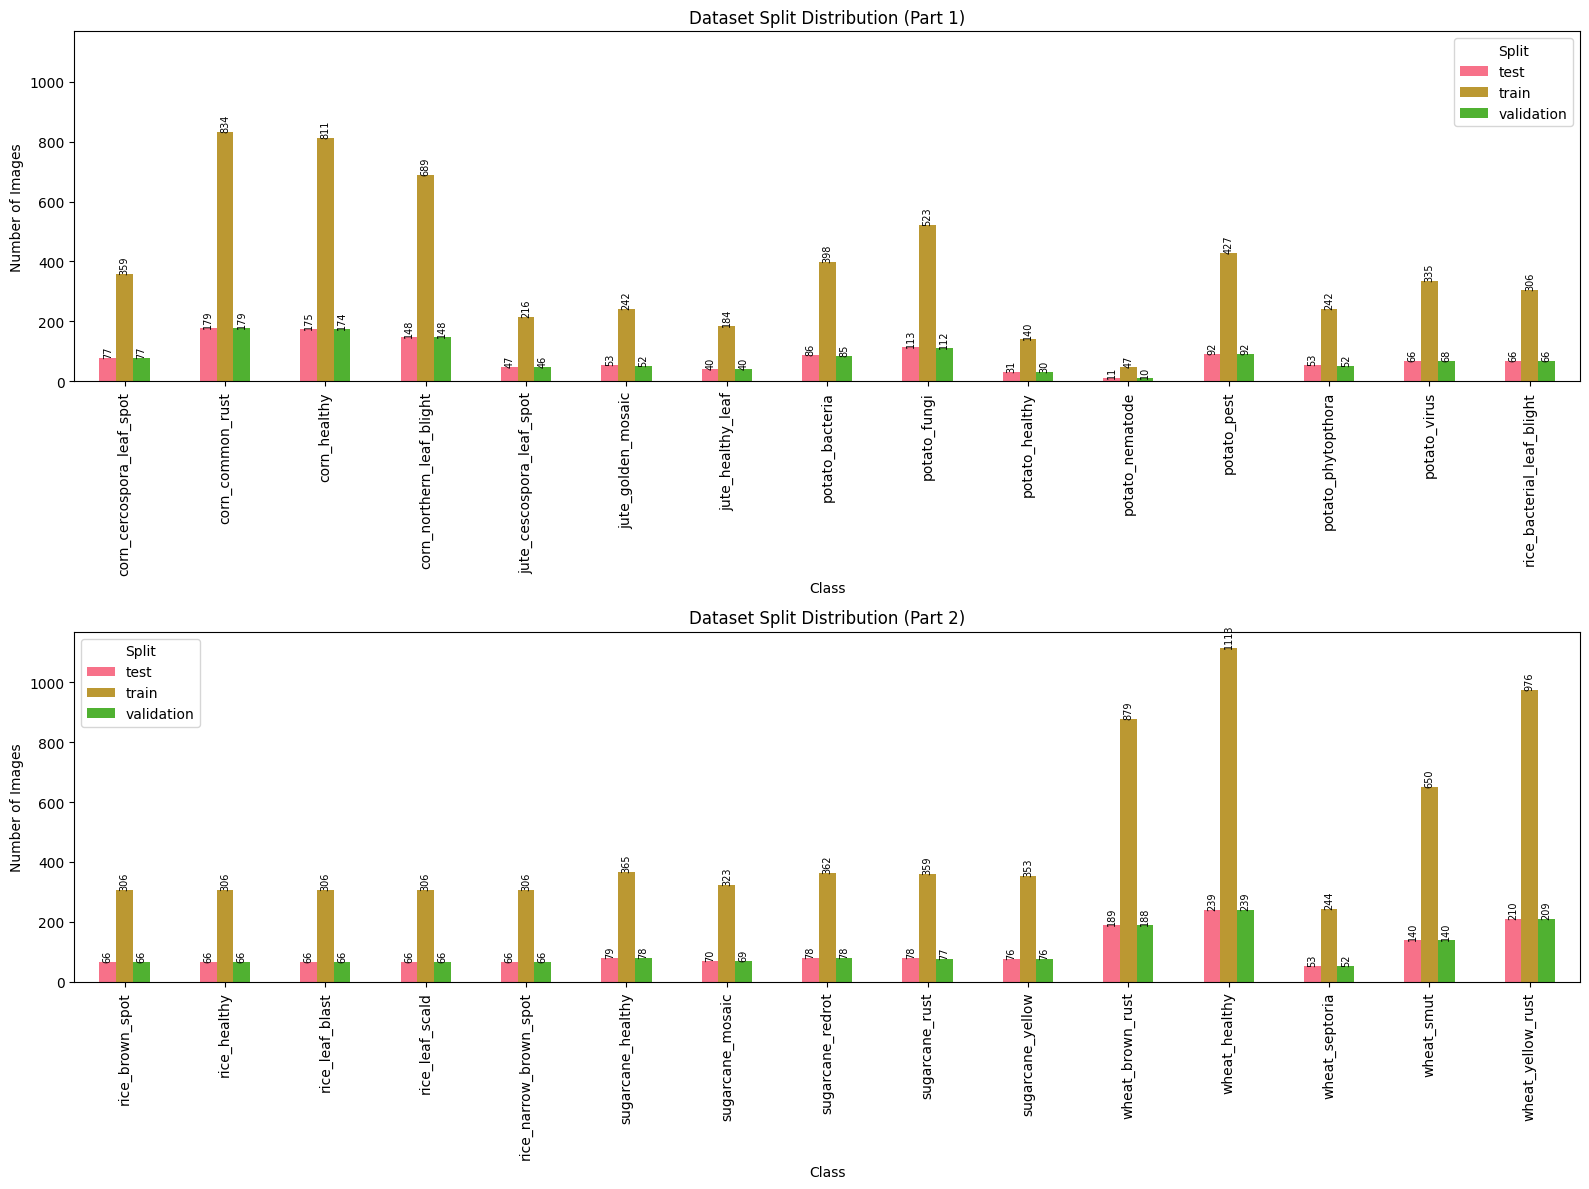

✅ Split distribution saved at: results\dataset_split_distribution.png


Split,test,train,validation
Class,,,
corn_cercospora_leaf_spot,77,359,77
corn_common_rust,179,834,179
corn_healthy,175,811,174
corn_northern_leaf_blight,148,689,148
jute_cescospora_leaf_spot,47,216,46
jute_golden_mosaic,53,242,52
jute_healthy_leaf,40,184,40
potato_bacteria,86,398,85
potato_fungi,113,523,112


In [6]:
processed_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/processed"
plot_split_distribution(processed_path)

## Dataset Class Definition 

In [7]:
print("\n=== Dataset Class Definition ===")

class AgroFusionNetDataset(Dataset):
    def __init__(self, data_dir, transform=None, class_to_idx=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # If mapping is not provided, create one from folder names
        if class_to_idx is None:
            classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            self.class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        else:
            self.class_to_idx = class_to_idx

        self.classes = list(self.class_to_idx.keys())

        # Collect images and labels
        for class_name, class_idx in self.class_to_idx.items():
            class_path = os.path.join(data_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_names(self):
        return self.classes


# === Create datasets ===
try:
    base_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/processed"
    # Step 1: Create train first (defines consistent mapping)
    train_dataset = AgroFusionNetDataset(os.path.join(base_path, "train"), transform=train_transform)
    
    # Step 2: Use same mapping for val & test
    val_dataset = AgroFusionNetDataset(os.path.join(base_path, "validation"), transform=val_transform, class_to_idx=train_dataset.class_to_idx)
    test_dataset = AgroFusionNetDataset(os.path.join(base_path,"test"), transform=val_transform, class_to_idx=train_dataset.class_to_idx)

    
    # === Print dataset info ===
    print(f"Train dataset: {len(train_dataset)} images, {len(train_dataset.classes)} classes")
    print(f"Validation dataset: {len(val_dataset)} images, {len(val_dataset.classes)} classes")
    print(f"Test dataset: {len(test_dataset)} images, {len(test_dataset.classes)} classes")
    
    print("\nSample class names:", train_dataset.classes[:5])
    print("\nClass-to-Index mapping:", train_dataset.class_to_idx)

except FileNotFoundError:
    print("Processed datasets not found. Please run data preprocessing first.")


=== Dataset Class Definition ===
Train dataset: 12907 images, 30 classes
Validation dataset: 2767 images, 30 classes
Test dataset: 2779 images, 30 classes

Sample class names: ['corn_cercospora_leaf_spot', 'corn_common_rust', 'corn_healthy', 'corn_northern_leaf_blight', 'jute_cescospora_leaf_spot']

Class-to-Index mapping: {'corn_cercospora_leaf_spot': 0, 'corn_common_rust': 1, 'corn_healthy': 2, 'corn_northern_leaf_blight': 3, 'jute_cescospora_leaf_spot': 4, 'jute_golden_mosaic': 5, 'jute_healthy_leaf': 6, 'potato_bacteria': 7, 'potato_fungi': 8, 'potato_healthy': 9, 'potato_nematode': 10, 'potato_pest': 11, 'potato_phytopthora': 12, 'potato_virus': 13, 'rice_bacterial_leaf_blight': 14, 'rice_brown_spot': 15, 'rice_healthy': 16, 'rice_leaf_blast': 17, 'rice_leaf_scald': 18, 'rice_narrow_brown_spot': 19, 'sugarcane_healthy': 20, 'sugarcane_mosaic': 21, 'sugarcane_redrot': 22, 'sugarcane_rust': 23, 'sugarcane_yellow': 24, 'wheat_brown_rust': 25, 'wheat_healthy': 26, 'wheat_septoria': 2

## Model Architecture

In [8]:
print("\n=== Model Architecture ===")

# Import timm for ConvNeXt-V2
import timm

class AttentionFusion(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(AttentionFusion, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        attention_weights = self.attention(x).unsqueeze(2).unsqueeze(3)
        return x * attention_weights

# AgroFusionNet with ConvNeXtV2

class AgroFusionNet(nn.Module):
    def __init__(self, num_classes, model_name='convnextv2_base', pretrained=True, freeze_backbone=True):
        super(AgroFusionNet, self).__init__()
        
        # Load pretrained ConvNeXt-V2
        self.backbone = timm.create_model(model_name, pretrained=pretrained, features_only=True)
        
        # Get feature dimensions (forward dummy input once)
        features = self.backbone(torch.randn(1, 3, 224, 224))  # changed to 224x224
        self.feature_dims = [f.shape[1] for f in features]
        
        # Attention fusion layers
        self.attention_layers = nn.ModuleList([
            AttentionFusion(dim) for dim in self.feature_dims
        ])
        
        # Adaptive pooling and classification head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(sum(self.feature_dims), 256),  # reduced hidden size from 512 → 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Optionally freeze backbone at the start
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
    def forward(self, x):
        features = self.backbone(x)
        
        # Apply attention to each feature level
        attended_features = []
        for feat, attn in zip(features, self.attention_layers):
            attended = attn(feat)
            pooled = self.global_pool(attended).squeeze(-1).squeeze(-1)
            attended_features.append(pooled)
            
        # Concatenate all features
        fused = torch.cat(attended_features, dim=1)
        
        # Classification
        output = self.classifier(fused)
        
        return output

# Initialize model
try:
    num_classes = len(train_dataset.classes)
    model = AgroFusionNet(num_classes=num_classes, freeze_backbone=True).to(device)  # freeze backbone first
    print(f"Model initialized with {num_classes} classes and moved to {device}")
    print(f"Backbone: ConvNeXt-V2 (base) with Attention Fusion")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters (after freezing): {trainable_params:,}")

except NameError:
    print("Datasets not loaded. Please run dataset cells first.")


=== Model Architecture ===
Model initialized with 30 classes and moved to cuda
Backbone: ConvNeXt-V2 (base) with Attention Fusion
Total parameters: 88,540,558
Trainable parameters (after freezing): 849,806


## Training Setup

In [9]:
print("\n=== Training Setup ===")

# Create data loaders
try:
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,        
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    print("✅ Data loaders created successfully!")
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

except NameError:
    print("Datasets not loaded. Please run dataset cells first.")


# Loss Function
criterion = nn.CrossEntropyLoss()
print("✅ Loss function defined (CrossEntropyLoss)")


# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,          
    weight_decay=0.01 
)
print("✅ Optimizer defined (AdamW)")


# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=20  # number of epochs before LR restarts
)
print("✅ Scheduler defined (CosineAnnealingLR)")


=== Training Setup ===
✅ Data loaders created successfully!
Train batches: 807
Validation batches: 173
Test batches: 174
✅ Loss function defined (CrossEntropyLoss)
✅ Optimizer defined (AdamW)
✅ Scheduler defined (CosineAnnealingLR)


## Training Function GPU Optimized

In [10]:
print("\n=== GPU-Optimized Training Function ===")


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25):
    model.to(device)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    best_acc = 0.0
    best_model_wts = None
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            # ✅ Use mixed precision for speed + memory
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            # ✅ AMP + Backprop
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.cpu())
        
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
 
        # Validation phase
        model.eval()
        running_loss, running_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.cpu())
        
        print(f"Val   Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        
        # Scheduler step
        if scheduler:
            scheduler.step()
            
        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, "results/best_model.pth")  # ✅ Save best model
        
        # Clear GPU cache each epoch
        torch.cuda.empty_cache()

    # Load best weights back
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Save training history
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }
    os.makedirs("results", exist_ok=True)
    np.save("C:/Users/ZA SEYAM/AgroFusionNet/results/training_history.npy", history)

    return model, history

print("✅ Training function defined!")


=== GPU-Optimized Training Function ===
✅ Training function defined!


## Model Training


=== Model Training ===
🚀 Starting training on cuda...
Training samples: 12907
Validation samples: 2767
Number of classes: 30

Epoch 1/30
--------------------


Train Loss: 0.7694 | Acc: 0.7706


Val   Loss: 0.3353 | Acc: 0.8793

Epoch 2/30
--------------------


Train Loss: 0.3094 | Acc: 0.8853


Val   Loss: 0.2438 | Acc: 0.9064

Epoch 3/30
--------------------


Train Loss: 0.2422 | Acc: 0.9107


Val   Loss: 0.2213 | Acc: 0.9223

Epoch 4/30
--------------------


Train Loss: 0.1975 | Acc: 0.9254


Val   Loss: 0.1963 | Acc: 0.9281

Epoch 5/30
--------------------


Train Loss: 0.1684 | Acc: 0.9386


Val   Loss: 0.1999 | Acc: 0.9270

Epoch 6/30
--------------------


Train Loss: 0.1561 | Acc: 0.9383


Val   Loss: 0.1759 | Acc: 0.9349

Epoch 7/30
--------------------


Train Loss: 0.1372 | Acc: 0.9494


Val   Loss: 0.1699 | Acc: 0.9353

Epoch 8/30
--------------------


Train Loss: 0.1127 | Acc: 0.9592


Val   Loss: 0.1618 | Acc: 0.9346

Epoch 9/30
--------------------


Train Loss: 0.1092 | Acc: 0.9586


Val   Loss: 0.1636 | Acc: 0.9378

Epoch 10/30
--------------------


Train Loss: 0.0935 | Acc: 0.9652


Val   Loss: 0.1725 | Acc: 0.9346

Epoch 11/30
--------------------


Train Loss: 0.0816 | Acc: 0.9720


Val   Loss: 0.1402 | Acc: 0.9490

Epoch 12/30
--------------------


Train Loss: 0.0706 | Acc: 0.9749


Val   Loss: 0.1487 | Acc: 0.9458

Epoch 13/30
--------------------


Train Loss: 0.0604 | Acc: 0.9786


Val   Loss: 0.1297 | Acc: 0.9469

Epoch 14/30
--------------------


Train Loss: 0.0551 | Acc: 0.9796


Val   Loss: 0.1298 | Acc: 0.9508

Epoch 15/30
--------------------


Train Loss: 0.0472 | Acc: 0.9838


Val   Loss: 0.1335 | Acc: 0.9519

Epoch 16/30
--------------------


Train Loss: 0.0401 | Acc: 0.9872


Val   Loss: 0.1364 | Acc: 0.9498

Epoch 17/30
--------------------


Train Loss: 0.0406 | Acc: 0.9864


Val   Loss: 0.1295 | Acc: 0.9516

Epoch 18/30
--------------------


Train Loss: 0.0376 | Acc: 0.9878


Val   Loss: 0.1289 | Acc: 0.9523

Epoch 19/30
--------------------


Train Loss: 0.0356 | Acc: 0.9892


Val   Loss: 0.1282 | Acc: 0.9519

Epoch 20/30
--------------------


Train Loss: 0.0332 | Acc: 0.9900


Val   Loss: 0.1283 | Acc: 0.9519

Epoch 21/30
--------------------


Train Loss: 0.0353 | Acc: 0.9892


Val   Loss: 0.1283 | Acc: 0.9519

Epoch 22/30
--------------------


Train Loss: 0.0357 | Acc: 0.9888


Val   Loss: 0.1285 | Acc: 0.9527

Epoch 23/30
--------------------


Train Loss: 0.0367 | Acc: 0.9881


Val   Loss: 0.1283 | Acc: 0.9516

Epoch 24/30
--------------------


Train Loss: 0.0337 | Acc: 0.9900


Val   Loss: 0.1295 | Acc: 0.9516

Epoch 25/30
--------------------


Train Loss: 0.0331 | Acc: 0.9895


Val   Loss: 0.1285 | Acc: 0.9530

Epoch 26/30
--------------------


Train Loss: 0.0347 | Acc: 0.9894


Val   Loss: 0.1321 | Acc: 0.9548

Epoch 27/30
--------------------


Train Loss: 0.0414 | Acc: 0.9856


Val   Loss: 0.1384 | Acc: 0.9487

Epoch 28/30
--------------------


Train Loss: 0.0372 | Acc: 0.9868


Val   Loss: 0.1373 | Acc: 0.9523

Epoch 29/30
--------------------


Train Loss: 0.0425 | Acc: 0.9854


Val   Loss: 0.1426 | Acc: 0.9498

Epoch 30/30
--------------------


Train Loss: 0.0462 | Acc: 0.9830


Val   Loss: 0.1463 | Acc: 0.9505
✅ Model trained and saved successfully!


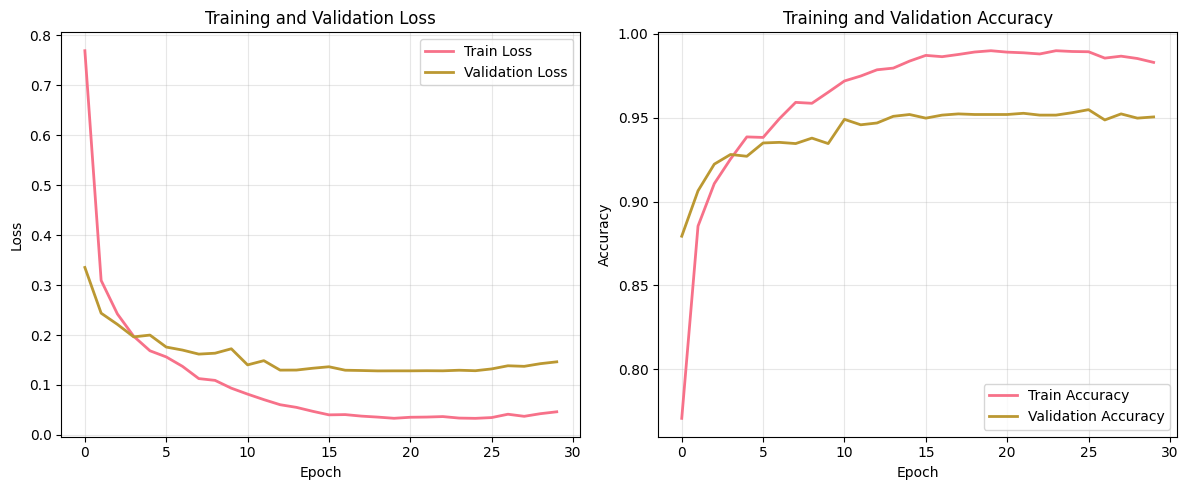

In [11]:
print("\n=== Model Training ===")

# Train model
try:
    print(f"🚀 Starting training on {device}...")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {num_classes}")
    
    model, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs=30  
    )
    
    # Save final model
    os.makedirs("models/trained", exist_ok=True)
    torch.save(model.state_dict(), "models/trained/agrofusionnet_final.pth")
    print("✅ Model trained and saved successfully!")

    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history["train_losses"], label="Train Loss", linewidth=2)
    plt.plot(history["val_losses"], label="Validation Loss", linewidth=2)
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history["train_accs"], label="Train Accuracy", linewidth=2)
    plt.plot(history["val_accs"], label="Validation Accuracy", linewidth=2)
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("C:/Users/ZA SEYAM/AgroFusionNet/results/training_history.png", dpi=300, bbox_inches="tight")
    plt.show()
    
except NameError as e:
    print("Model or data loaders not initialized. Please run previous cells first.")
    print(e)



=== Model Evaluation & Metrics ===


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 174/174 [01:20<00:00,  2.15it/s]



 Test Accuracy: 0.9493


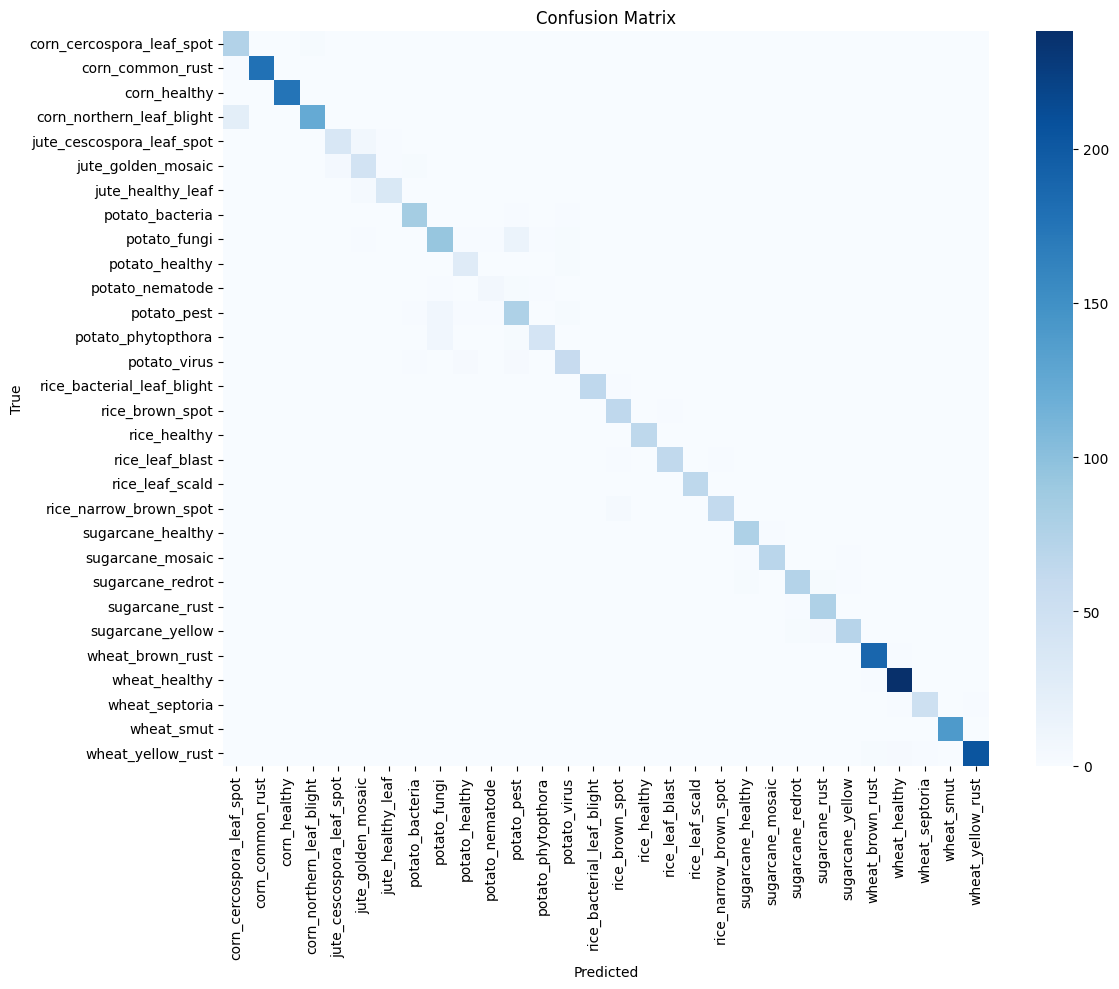


Classification Report:
                             precision    recall  f1-score   support

 corn_cercospora_leaf_spot     0.7426    0.9740    0.8427        77
          corn_common_rust     1.0000    0.9944    0.9972       179
              corn_healthy     1.0000    1.0000    1.0000       175
 corn_northern_leaf_blight     0.9840    0.8311    0.9011       148
 jute_cescospora_leaf_spot     0.8837    0.8085    0.8444        47
        jute_golden_mosaic     0.7759    0.8491    0.8108        53
         jute_healthy_leaf     0.9474    0.9000    0.9231        40
           potato_bacteria     0.9545    0.9767    0.9655        86
              potato_fungi     0.8304    0.8230    0.8267       113
            potato_healthy     0.8529    0.9355    0.8923        31
           potato_nematode     0.7778    0.6364    0.7000        11
               potato_pest     0.7800    0.8478    0.8125        92
        potato_phytopthora     0.9545    0.7925    0.8660        53
              potato_v

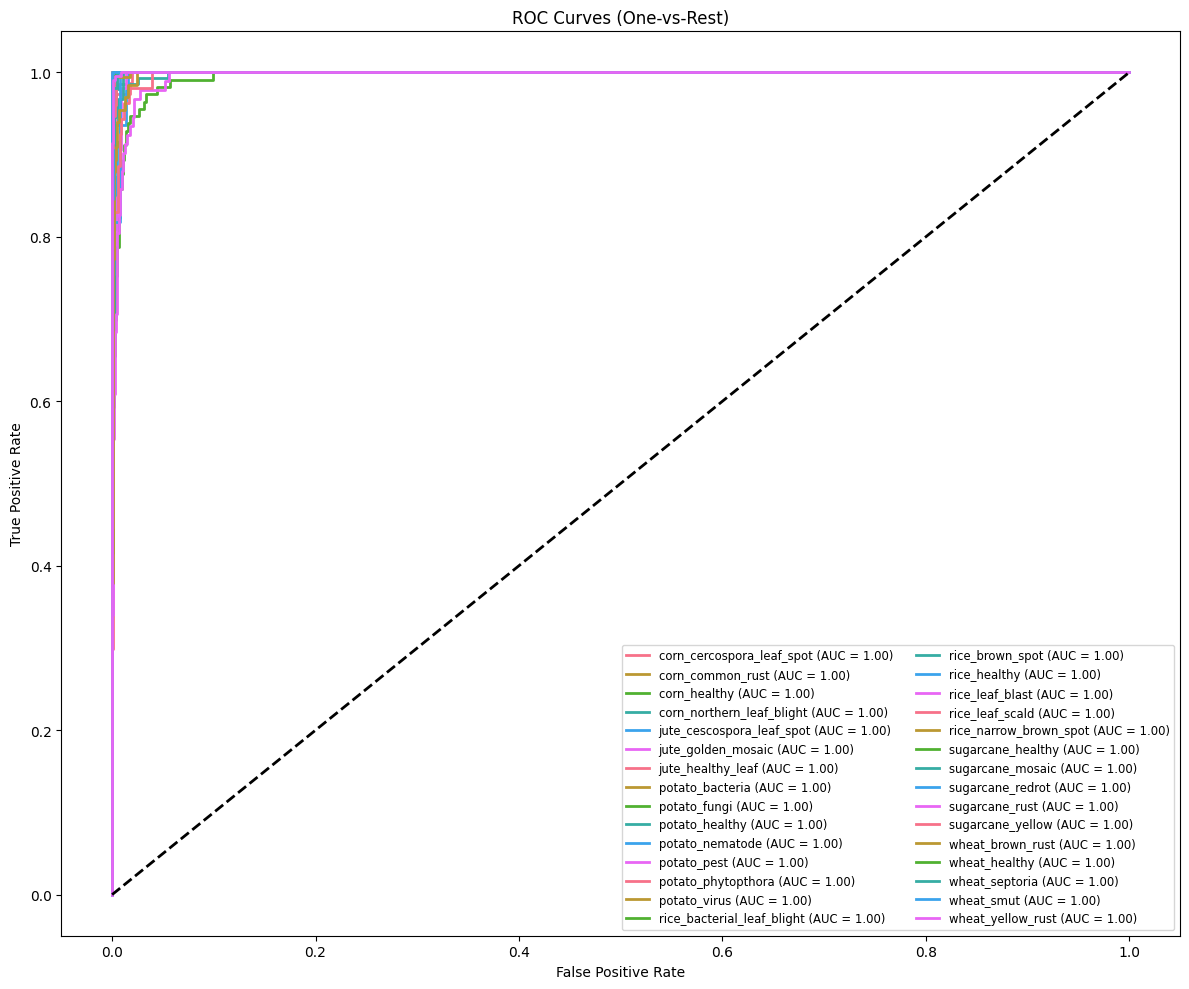

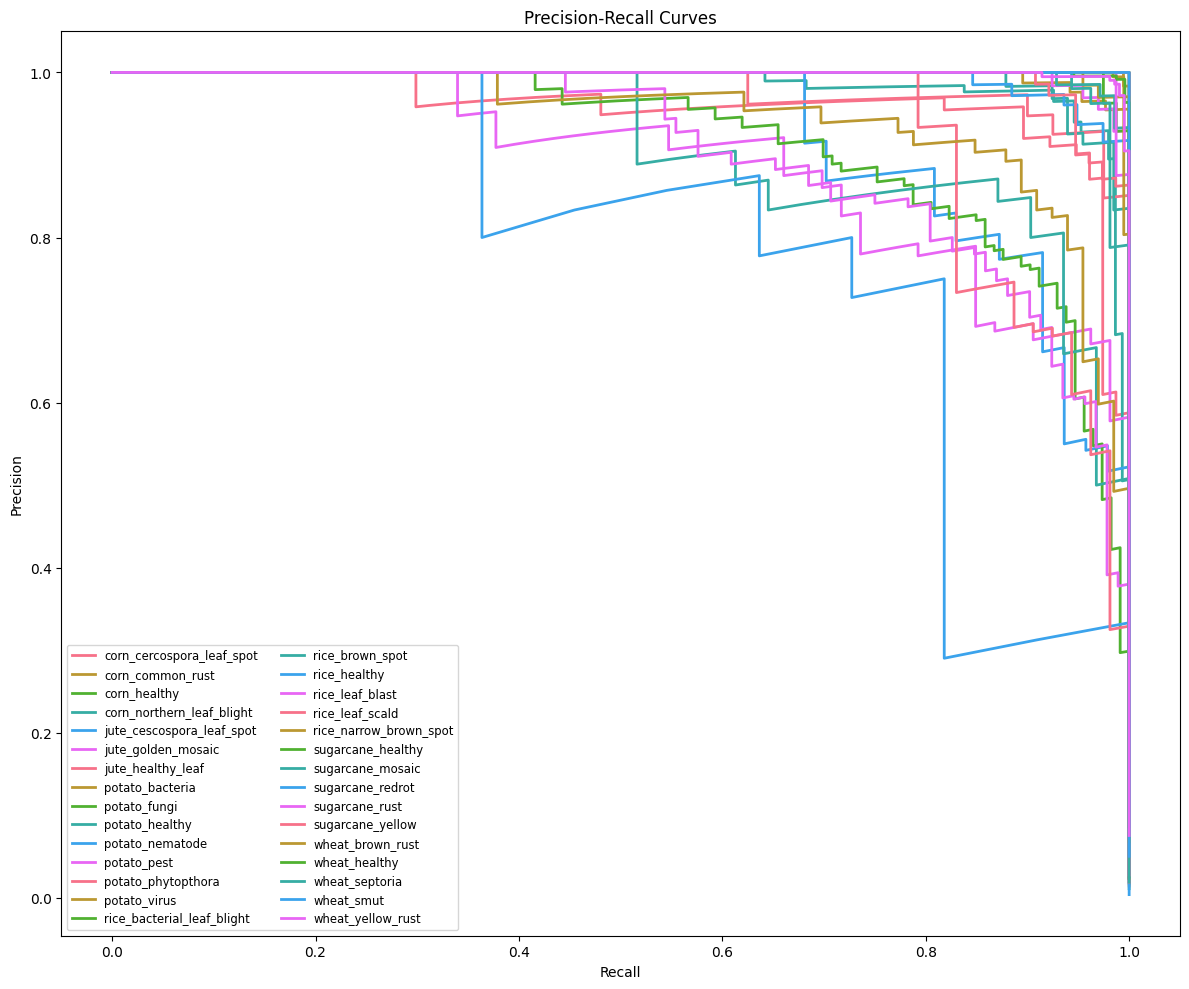

In [14]:
print("\n=== Model Evaluation & Metrics ===")
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# === Overall Accuracy ===
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n Test Accuracy: {test_acc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("C:/Users/ZA SEYAM/AgroFusionNet/results/confusion_matrix.png", dpi=300)
plt.show()

# === Classification Report ===
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=4)
print("\nClassification Report:\n", report)

# === ROC Curves ===
n_classes = len(train_dataset.classes)
y_true_bin = label_binarize(all_labels, classes=np.arange(n_classes))

plt.figure(figsize=(12, 10))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{train_dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.tight_layout()
plt.savefig("C:/Users/ZA SEYAM/AgroFusionNet/results/roc_curves.png", dpi=300)
plt.show()

# === Precision-Recall Curves ===
plt.figure(figsize=(12, 10))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"{train_dataset.classes[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best", fontsize="small", ncol=2)
plt.tight_layout()
plt.savefig("C:/Users/ZA SEYAM/AgroFusionNet/results/precision_recall_curves.png", dpi=300)
plt.show()

In [16]:
#Calculation the Accuracy
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:   # or val_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # predicted class index

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Now calculate accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Overall Accuracy: {accuracy:.2f}%")

Overall Accuracy: 94.93%


✅ Saved: C:/Users/ZA SEYAM/AgroFusionNet/results/confusion_matrix_part1.png


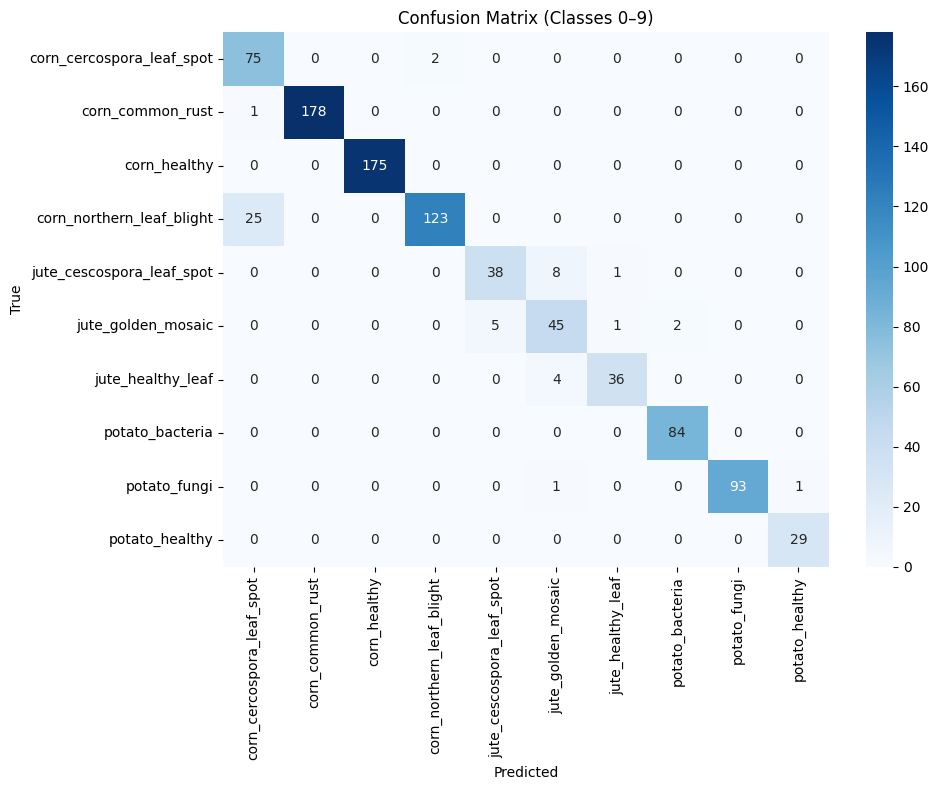

✅ Saved: C:/Users/ZA SEYAM/AgroFusionNet/results/confusion_matrix_part2.png


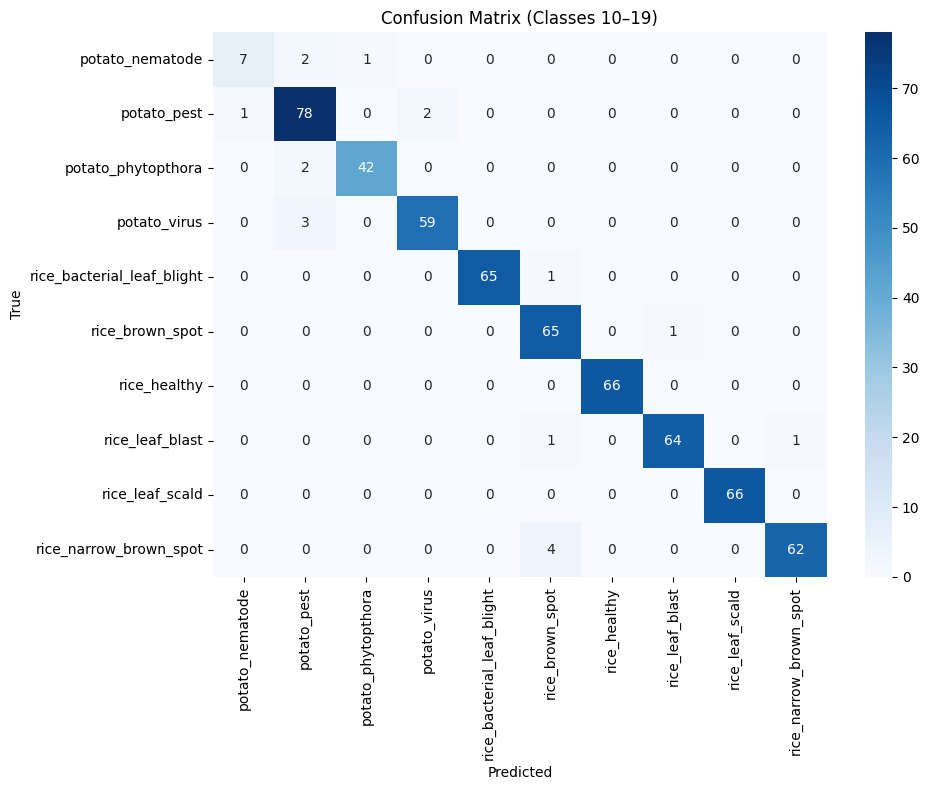

✅ Saved: C:/Users/ZA SEYAM/AgroFusionNet/results/confusion_matrix_part3.png


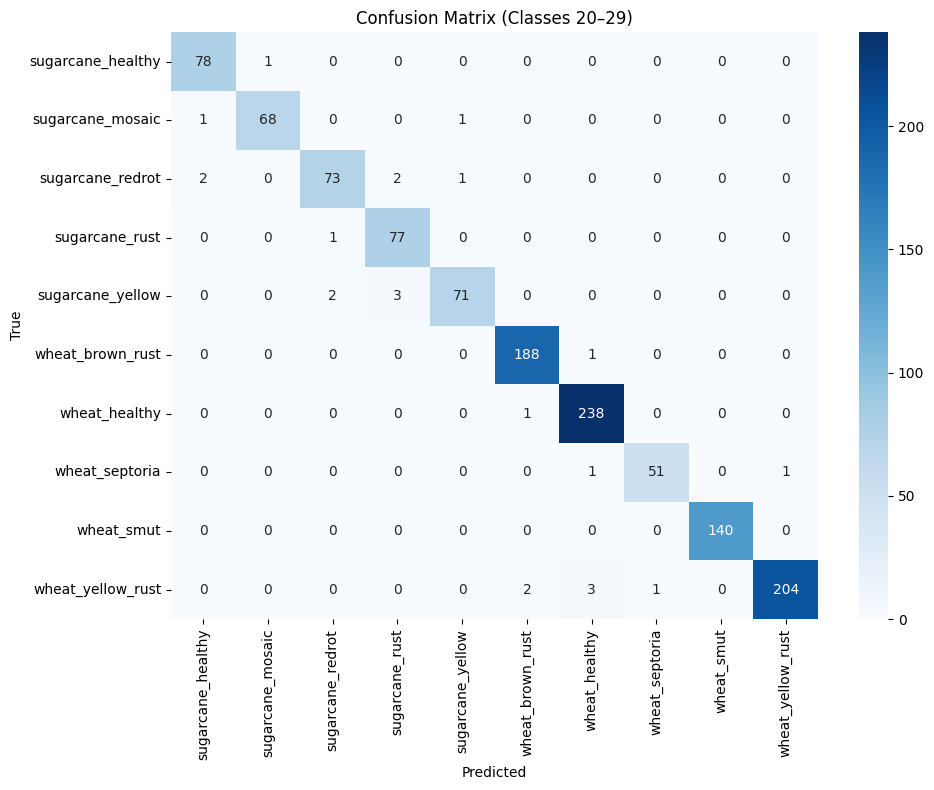

In [18]:
cm = confusion_matrix(y_true, y_pred)
classes = list(test_dataset.classes)  

def plot_and_save_split_confusion_matrix(cm, classes, chunk_size=10, save_path="results/"):
    n = len(classes)
    num_chunks = (n + chunk_size - 1) // chunk_size  

    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm[start:end, start:end], annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes[start:end], yticklabels=classes[start:end])
        plt.title(f"Confusion Matrix (Classes {start}–{end-1})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        
        # Save each part
        filename = f"{save_path}confusion_matrix_part{i+1}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {filename}")
        
        plt.show()

# Example usage: split into chunks of 10
plot_and_save_split_confusion_matrix(cm, classes, chunk_size=10, save_path="C:/Users/ZA SEYAM/AgroFusionNet/results/")

## Classification Report

In [19]:
print(classification_report(y_true, y_pred, target_names=classes))

                            precision    recall  f1-score   support

 corn_cercospora_leaf_spot       0.74      0.97      0.84        77
          corn_common_rust       1.00      0.99      1.00       179
              corn_healthy       1.00      1.00      1.00       175
 corn_northern_leaf_blight       0.98      0.83      0.90       148
 jute_cescospora_leaf_spot       0.88      0.81      0.84        47
        jute_golden_mosaic       0.78      0.85      0.81        53
         jute_healthy_leaf       0.95      0.90      0.92        40
           potato_bacteria       0.95      0.98      0.97        86
              potato_fungi       0.83      0.82      0.83       113
            potato_healthy       0.85      0.94      0.89        31
           potato_nematode       0.78      0.64      0.70        11
               potato_pest       0.78      0.85      0.81        92
        potato_phytopthora       0.95      0.79      0.87        53
              potato_virus       0.89      0.89

## Per Class Accuracy

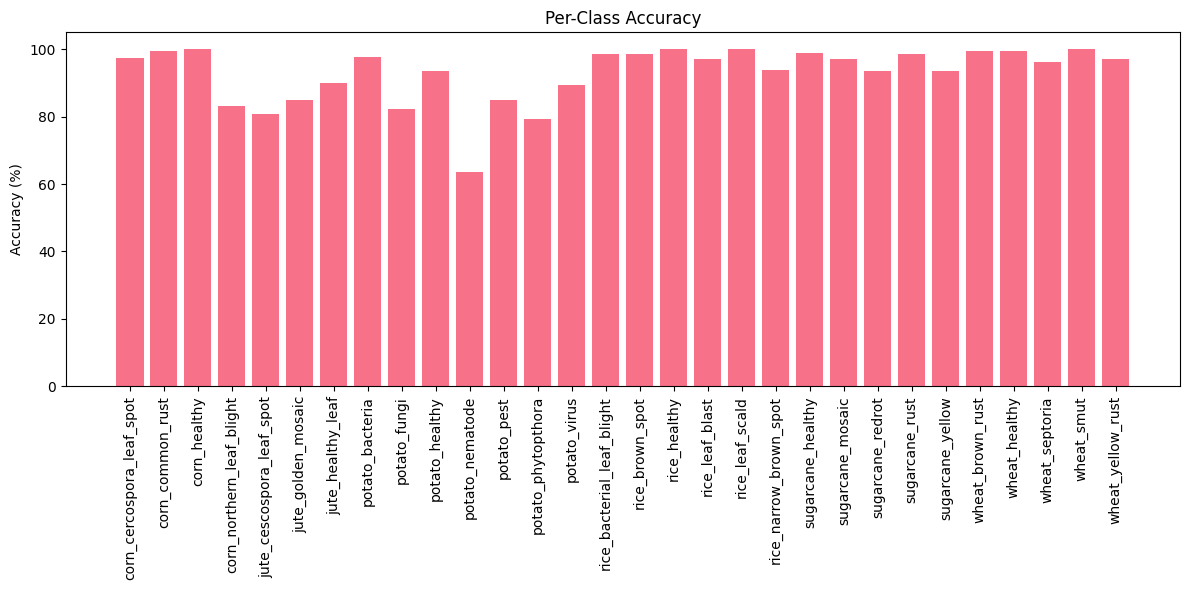

In [20]:
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12,6))
plt.bar(range(len(classes)), per_class_acc*100)
plt.xticks(range(len(classes)), classes, rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.savefig("results/per_class_accuracy.png", dpi=300)
plt.show()